### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [6]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

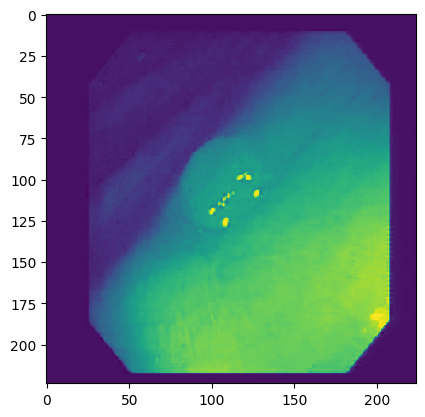

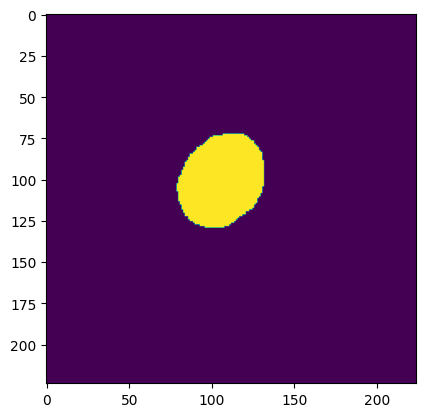

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
from models.sotor_medical_seg_models.ESFPNet.ESFPmodel import ESFPNetStructure

model = ESFPNetStructure(embedding_dim = 224)
model = model.to(DEVICE)

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'ESFPNet'
data_name = 'CVC'

# 5. Training

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 0.800186, IoU: 0.279941, Dice: 0.374003
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 0.607680, IoU: 0.423061, Dice: 0.529434

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


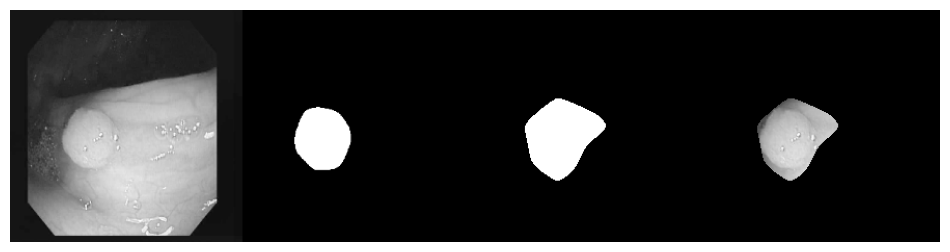

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 0.481768, IoU: 0.491786, Dice: 0.610355
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 0.504278, IoU: 0.503248, Dice: 0.629801


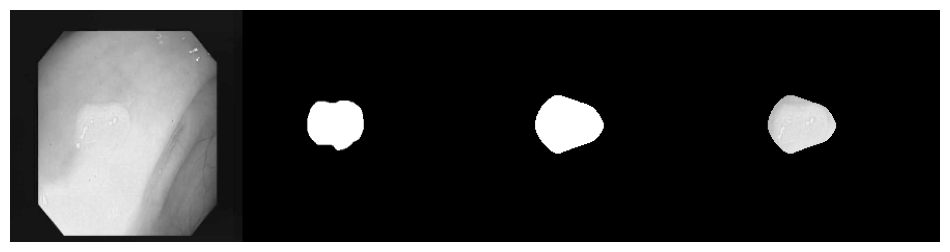

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 0.379951, IoU: 0.558727, Dice: 0.672500
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 0.401276, IoU: 0.572364, Dice: 0.690848


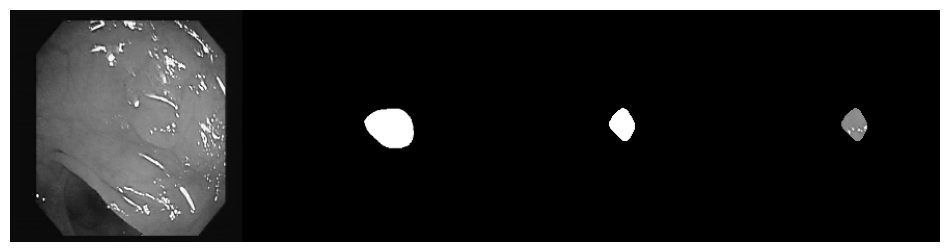

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 0.299682, IoU: 0.623739, Dice: 0.732847
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 0.361922, IoU: 0.608148, Dice: 0.722118


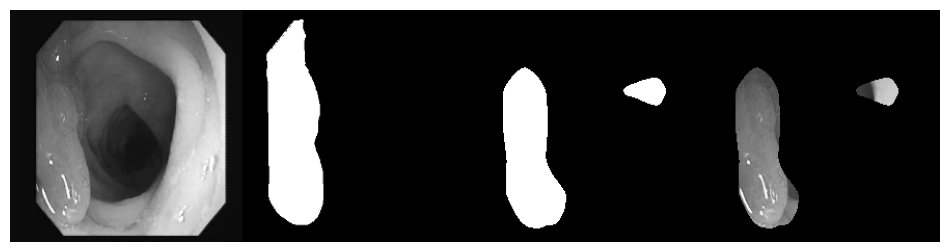

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 0.253504, IoU: 0.665934, Dice: 0.773072
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 0.350770, IoU: 0.609518, Dice: 0.721523


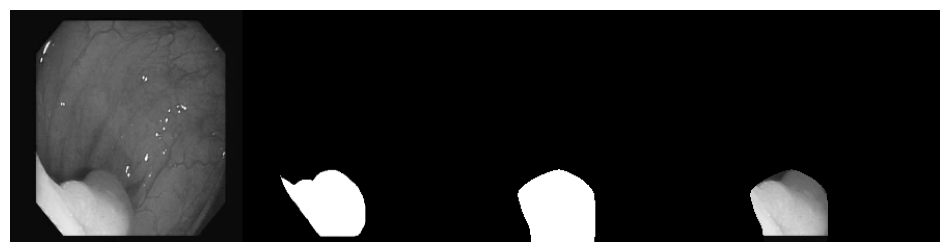

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 0.234789, IoU: 0.687857, Dice: 0.786756
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 0.304519, IoU: 0.657827, Dice: 0.760462


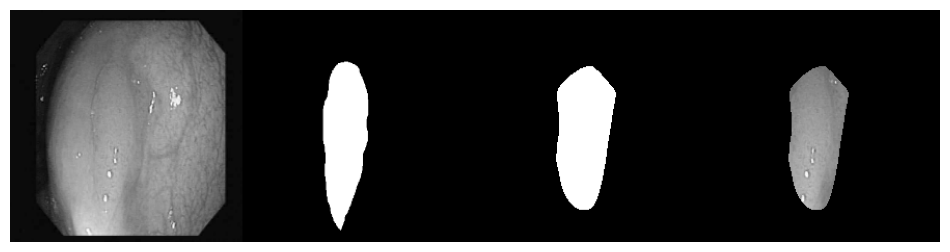

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.204916, IoU: 0.716209, Dice: 0.811251
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 0.304320, IoU: 0.672306, Dice: 0.773828


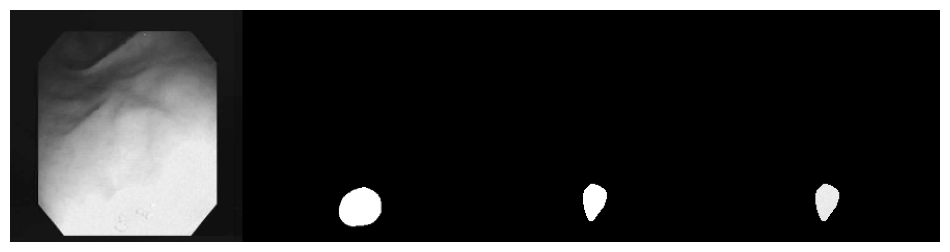

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.201560, IoU: 0.723591, Dice: 0.814222
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 0.310609, IoU: 0.658007, Dice: 0.765974


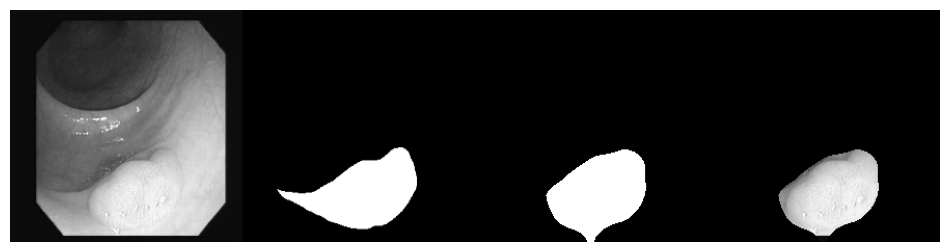

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.183550, IoU: 0.751827, Dice: 0.838914
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 0.259841, IoU: 0.697894, Dice: 0.792228


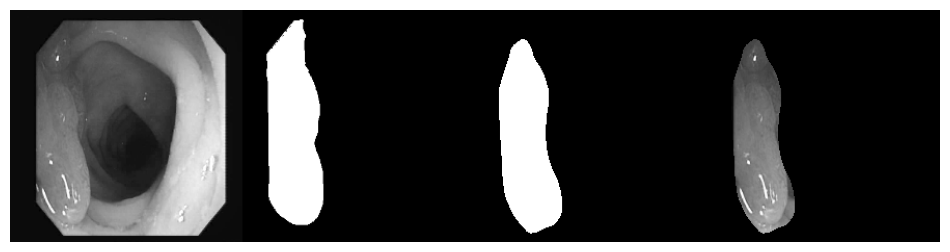

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.160477, IoU: 0.774115, Dice: 0.855148
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 0.259328, IoU: 0.703909, Dice: 0.795673


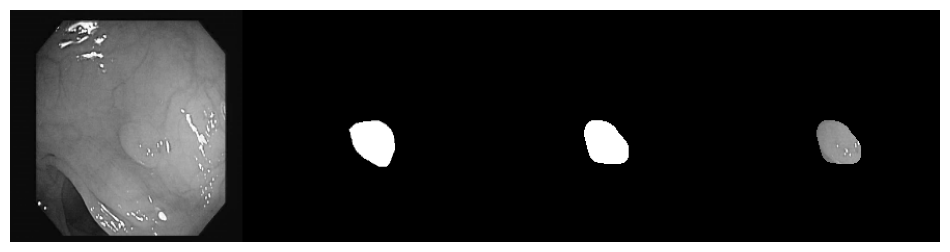

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.142392, IoU: 0.792067, Dice: 0.868966
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.249831, IoU: 0.713464, Dice: 0.806582


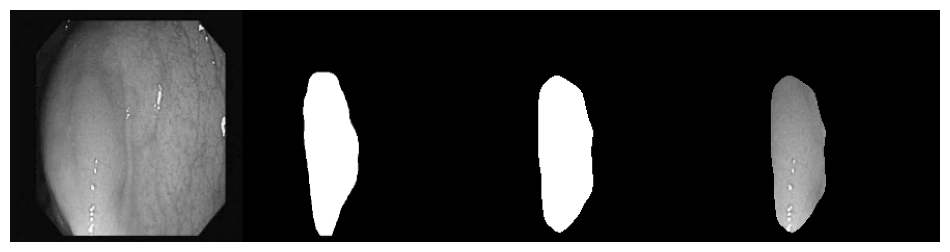

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.147540, IoU: 0.791850, Dice: 0.869429
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.250643, IoU: 0.717815, Dice: 0.807650


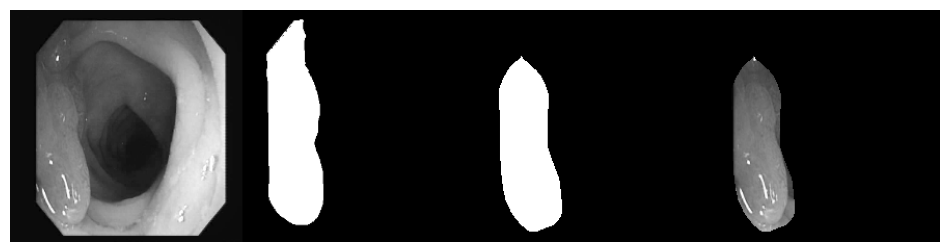

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.139588, IoU: 0.800788, Dice: 0.875262
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.247154, IoU: 0.724289, Dice: 0.814925


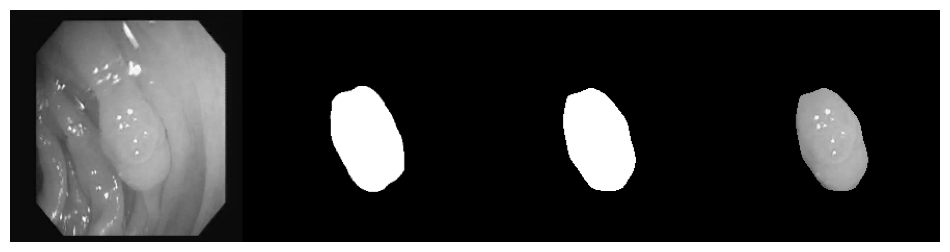

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.129851, IoU: 0.813534, Dice: 0.883172
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.275637, IoU: 0.708576, Dice: 0.798675


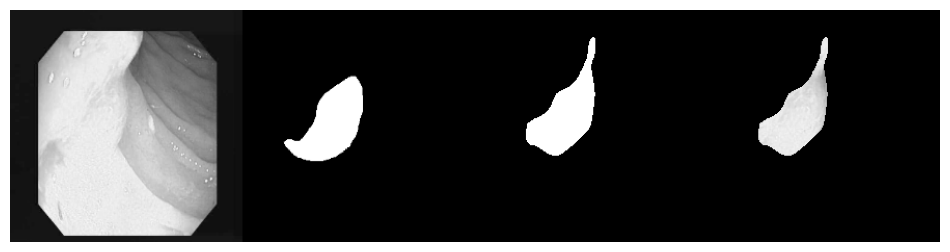

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.117304, IoU: 0.826504, Dice: 0.892503
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.250181, IoU: 0.722727, Dice: 0.813064


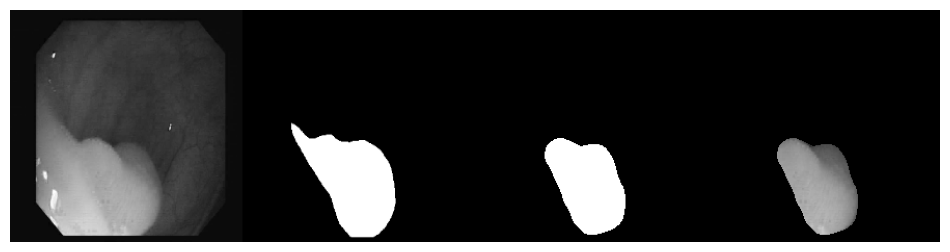

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.118303, IoU: 0.827498, Dice: 0.893969
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.263931, IoU: 0.721915, Dice: 0.813331


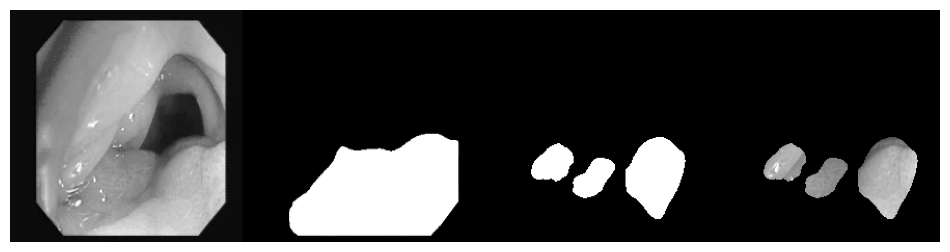

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.111350, IoU: 0.832264, Dice: 0.897292
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.263529, IoU: 0.729154, Dice: 0.817496


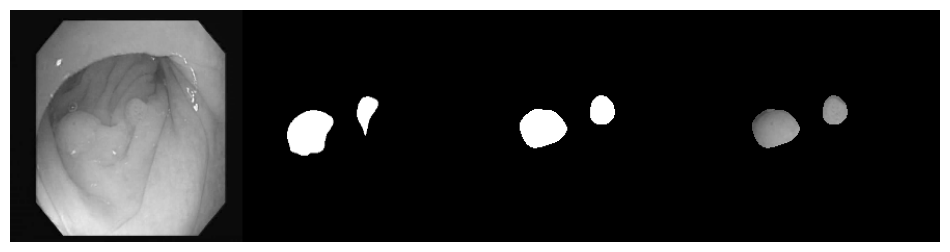

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.107450, IoU: 0.834680, Dice: 0.897162
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.249592, IoU: 0.732538, Dice: 0.820615


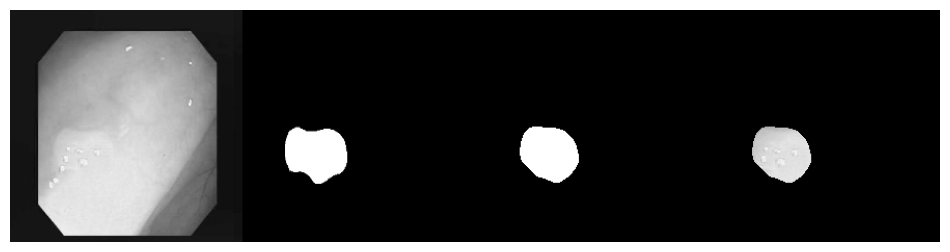

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.103281, IoU: 0.841010, Dice: 0.901855
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.260400, IoU: 0.731258, Dice: 0.816618


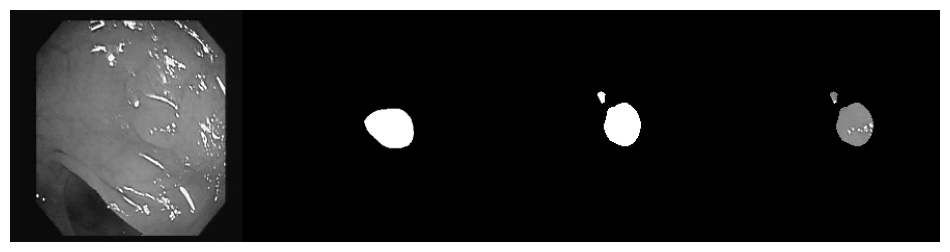

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.101340, IoU: 0.843296, Dice: 0.903671
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.233578, IoU: 0.740863, Dice: 0.827313


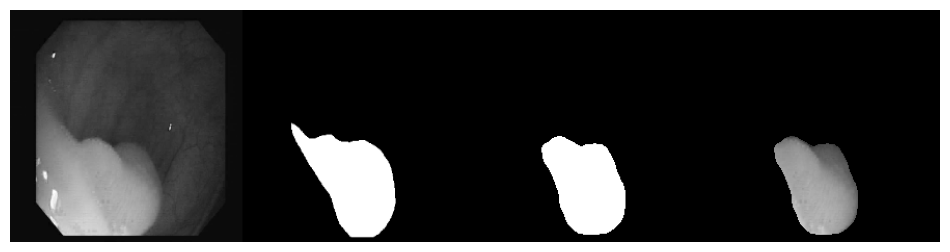

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.094913, IoU: 0.851649, Dice: 0.909572
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.261449, IoU: 0.726737, Dice: 0.816702


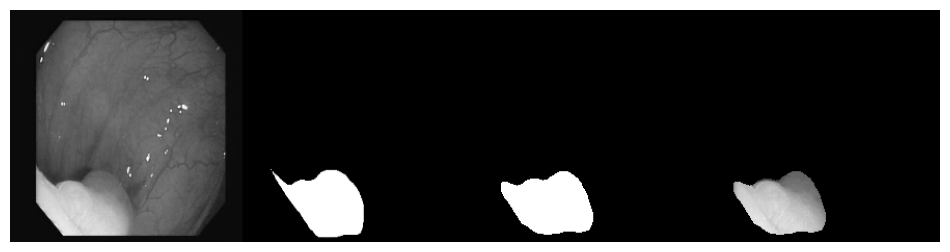

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.095954, IoU: 0.850513, Dice: 0.908396
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.250167, IoU: 0.741039, Dice: 0.827686


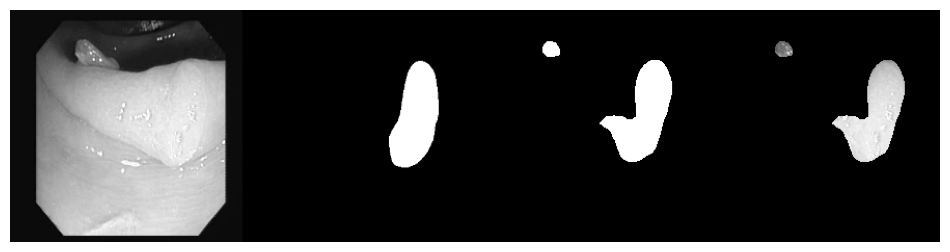

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.090390, IoU: 0.864002, Dice: 0.921096
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.244296, IoU: 0.745235, Dice: 0.829726


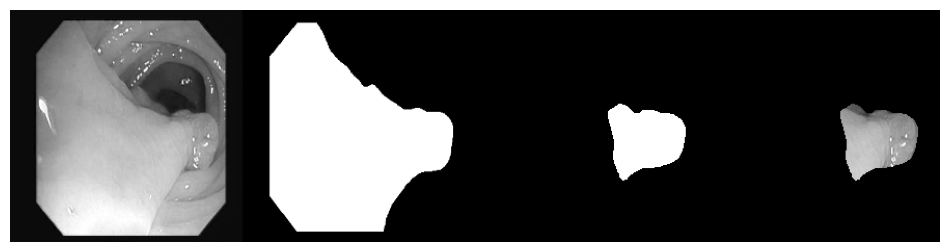

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.099989, IoU: 0.850398, Dice: 0.909983
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.293417, IoU: 0.718619, Dice: 0.807874


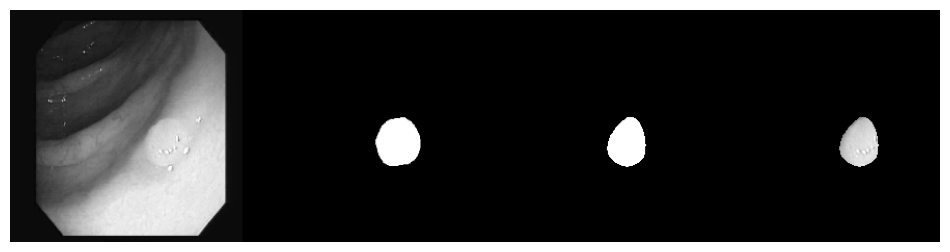

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.095704, IoU: 0.859194, Dice: 0.918169
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.240392, IoU: 0.742051, Dice: 0.823689


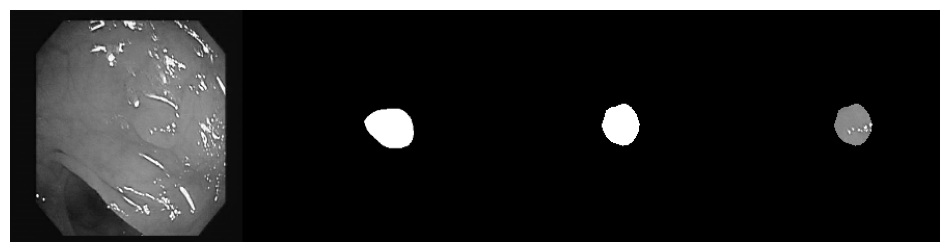

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.095938, IoU: 0.850215, Dice: 0.906735
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.219407, IoU: 0.753600, Dice: 0.836937


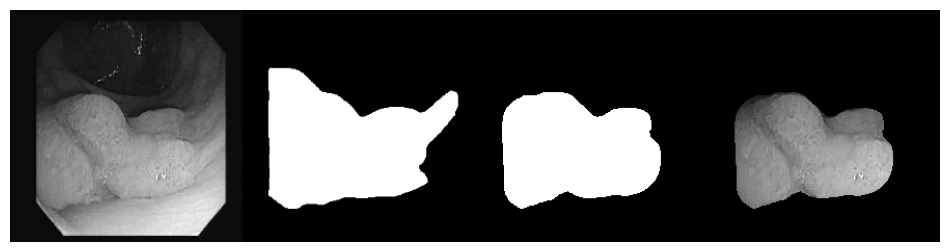

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.085396, IoU: 0.866170, Dice: 0.920760
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.227919, IoU: 0.759108, Dice: 0.841392


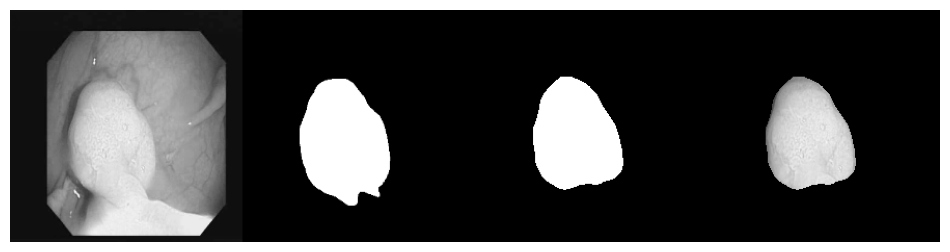

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.079492, IoU: 0.873654, Dice: 0.926292
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.229584, IoU: 0.759213, Dice: 0.841072


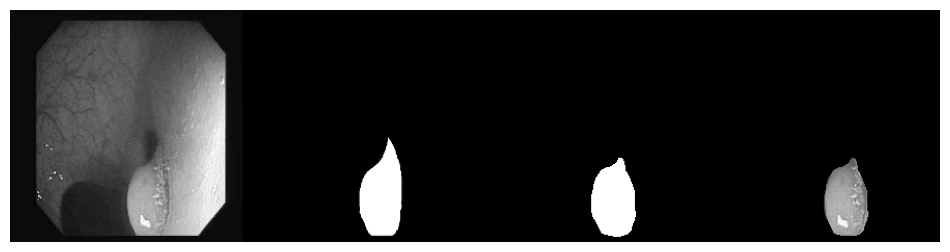

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.089114, IoU: 0.869260, Dice: 0.923577
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.228686, IoU: 0.741717, Dice: 0.826951


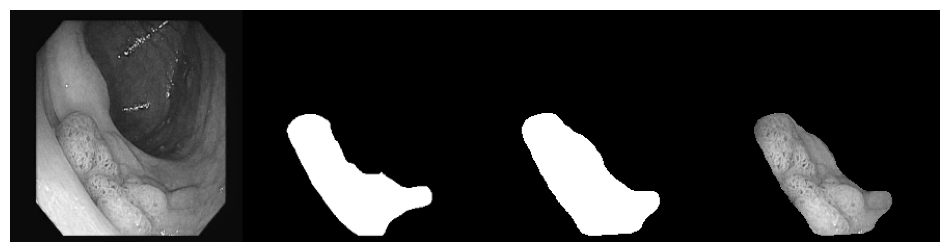

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.082317, IoU: 0.874379, Dice: 0.927367
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.232604, IoU: 0.752023, Dice: 0.833936


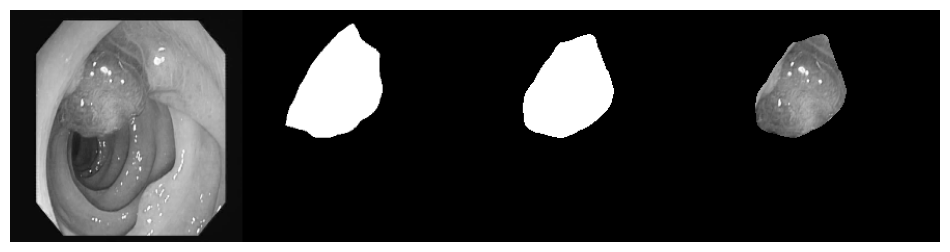

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.082775, IoU: 0.872242, Dice: 0.923686
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.231147, IoU: 0.755815, Dice: 0.840957


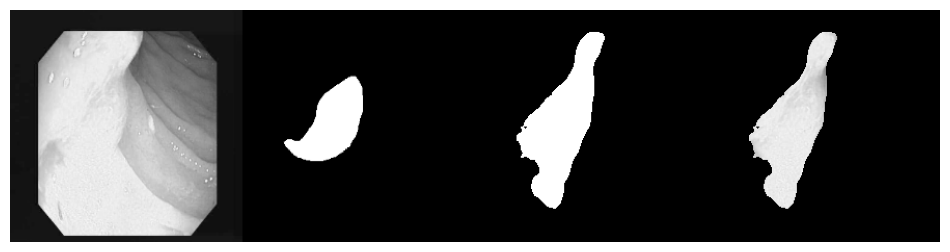

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.077277, IoU: 0.877677, Dice: 0.927615
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.248833, IoU: 0.748703, Dice: 0.831753


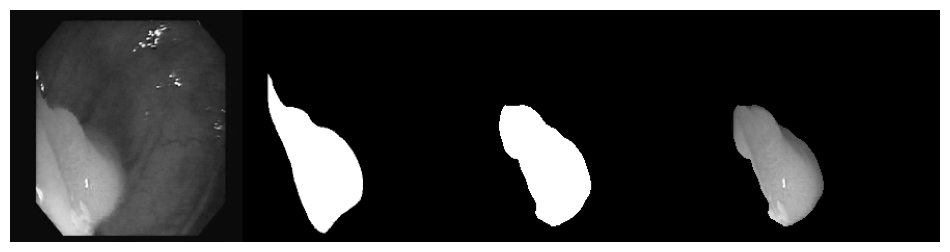

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.073219, IoU: 0.886559, Dice: 0.936790
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.236966, IoU: 0.752063, Dice: 0.833609


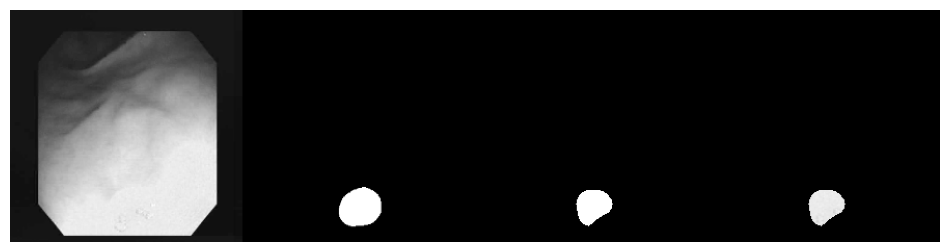

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.074155, IoU: 0.888013, Dice: 0.936732
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.229956, IoU: 0.756675, Dice: 0.839313


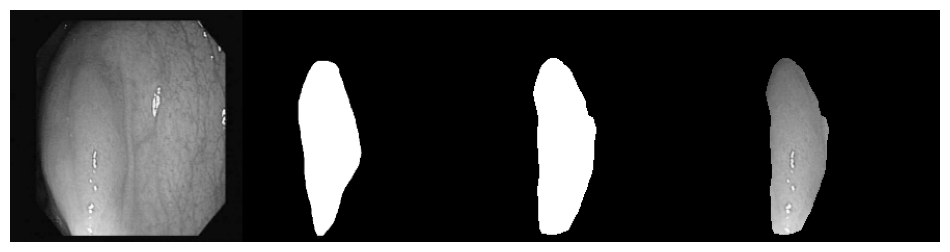

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.075726, IoU: 0.883851, Dice: 0.931646
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.244301, IoU: 0.752660, Dice: 0.837349


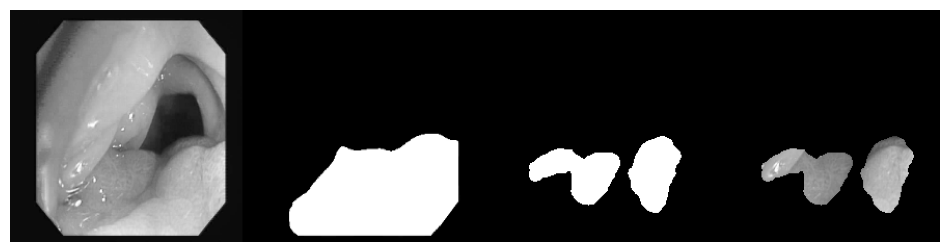

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.069196, IoU: 0.891953, Dice: 0.938894
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.236490, IoU: 0.757284, Dice: 0.838886


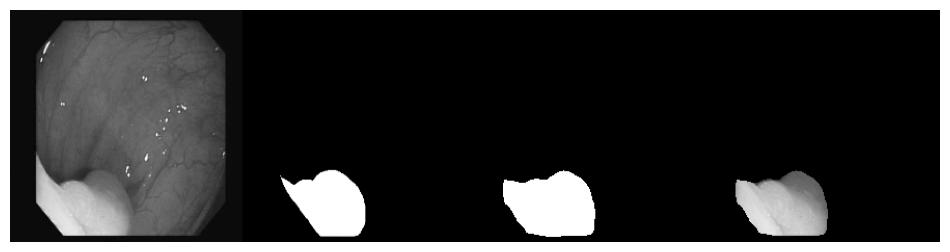

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.064886, IoU: 0.896694, Dice: 0.942451
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.236886, IoU: 0.757497, Dice: 0.837766


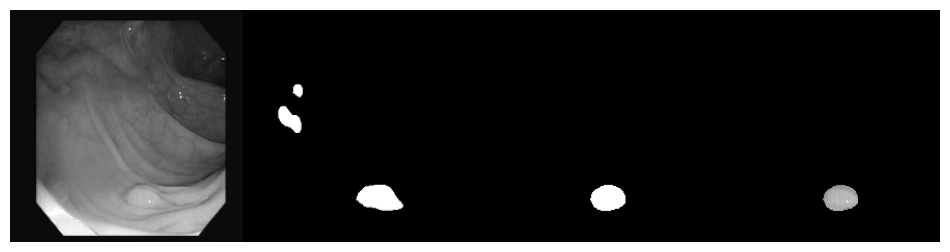

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.072184, IoU: 0.889141, Dice: 0.937012
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.247064, IoU: 0.753800, Dice: 0.839723


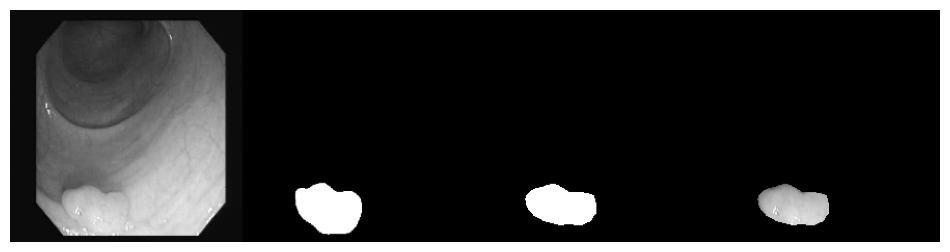

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.069311, IoU: 0.890511, Dice: 0.938211
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.224807, IoU: 0.766265, Dice: 0.848465


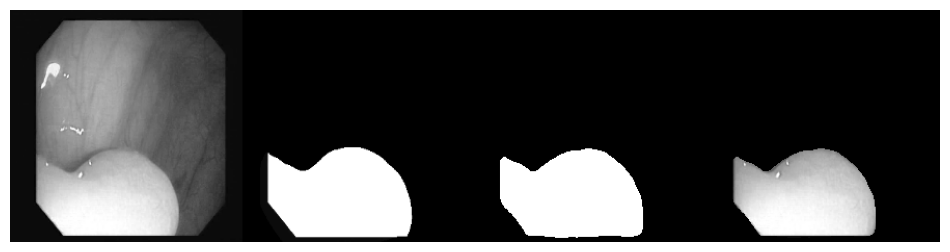

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.065069, IoU: 0.898348, Dice: 0.943277
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.250636, IoU: 0.760956, Dice: 0.842451


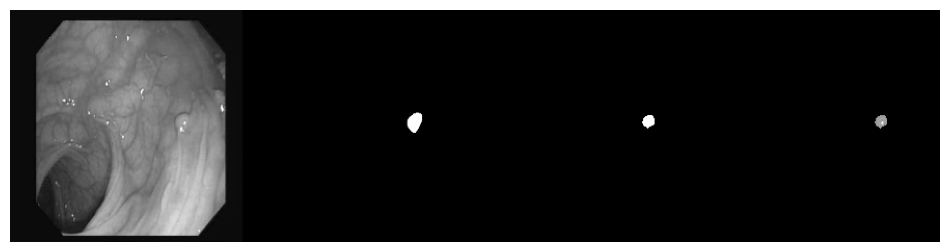

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.061671, IoU: 0.904824, Dice: 0.948301
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.238873, IoU: 0.767636, Dice: 0.848004


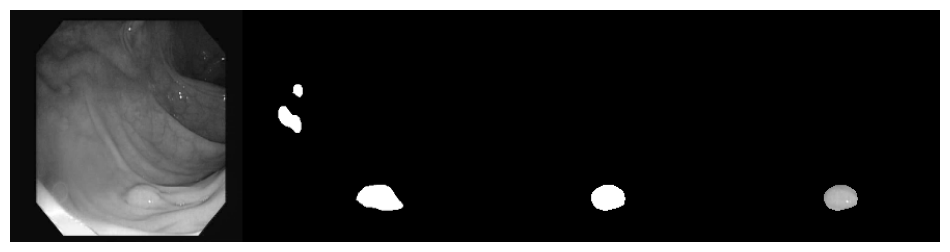

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.060374, IoU: 0.908184, Dice: 0.950134
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.218800, IoU: 0.766106, Dice: 0.845113


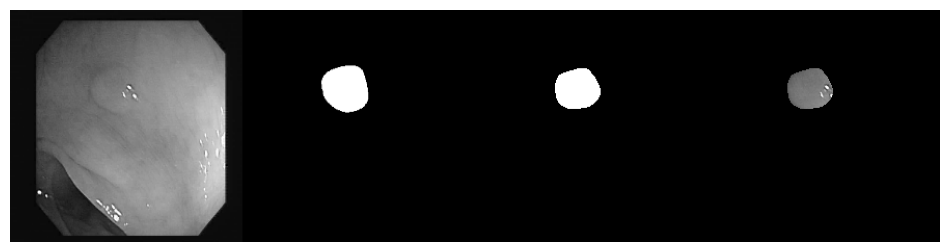

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.059016, IoU: 0.902282, Dice: 0.943782
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.248255, IoU: 0.768386, Dice: 0.849720


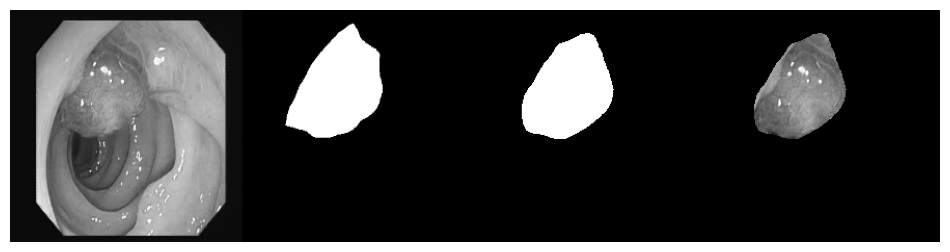

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.068433, IoU: 0.895213, Dice: 0.939430
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.261601, IoU: 0.754637, Dice: 0.837123


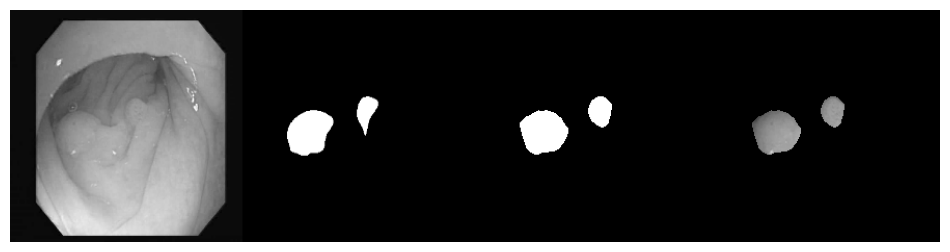

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.068639, IoU: 0.896565, Dice: 0.942262
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.266053, IoU: 0.757701, Dice: 0.838093


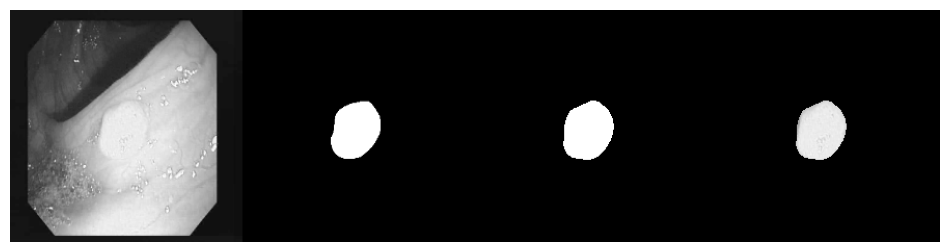

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.065680, IoU: 0.898291, Dice: 0.941757
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.263353, IoU: 0.759564, Dice: 0.845238


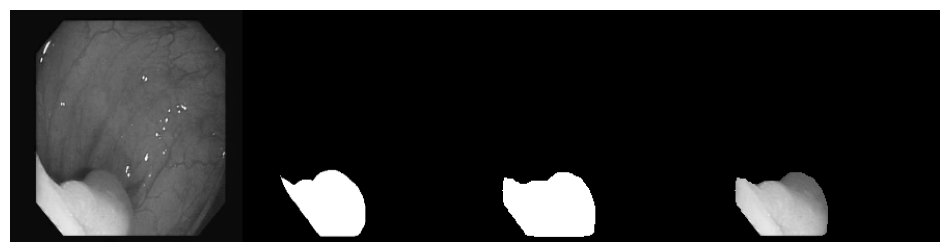

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.064784, IoU: 0.900452, Dice: 0.945527
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.238408, IoU: 0.764330, Dice: 0.845760


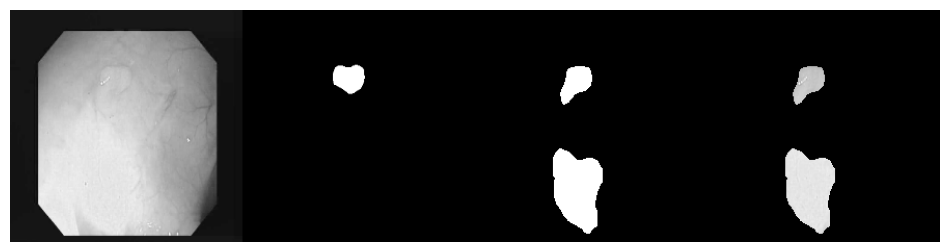

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.069108, IoU: 0.898381, Dice: 0.943256
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.314752, IoU: 0.730801, Dice: 0.815089


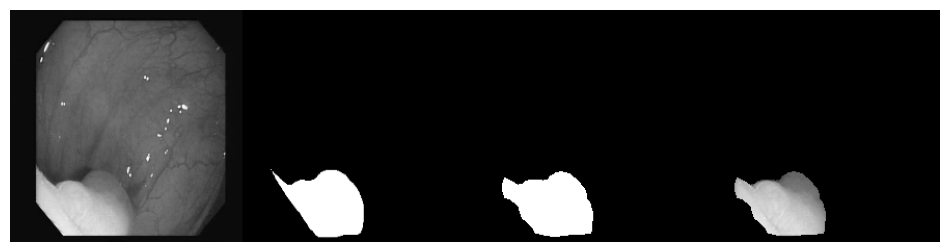

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.092928, IoU: 0.889274, Dice: 0.937703
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.270677, IoU: 0.737091, Dice: 0.821320


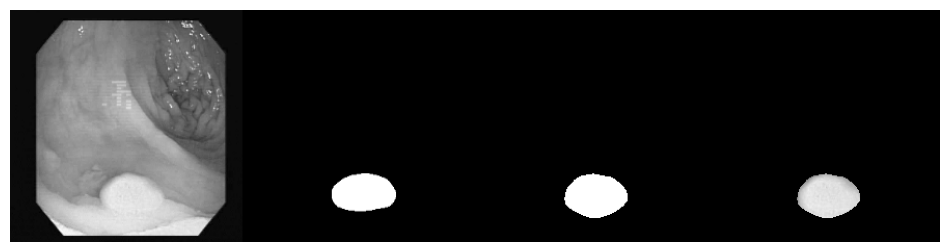

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.067979, IoU: 0.895174, Dice: 0.940858
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.245706, IoU: 0.767562, Dice: 0.845855


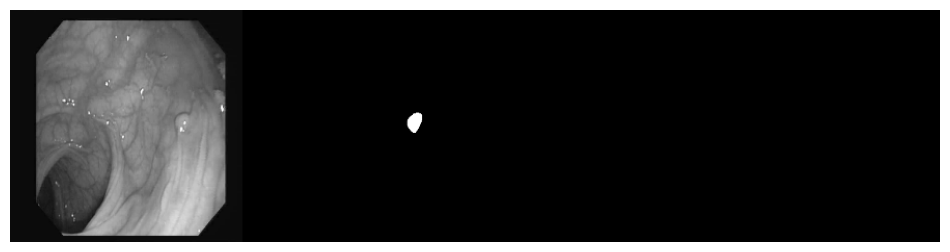

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.061371, IoU: 0.902805, Dice: 0.944838
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.235946, IoU: 0.765082, Dice: 0.844597


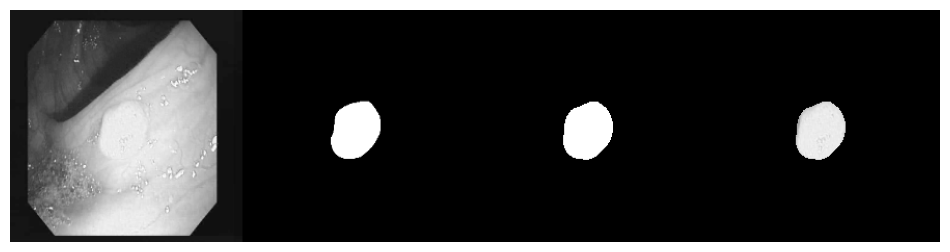

 Epoch: 52 of 100, Iter.: 46 of 46, Train Loss: 0.054325, IoU: 0.912741, Dice: 0.952691
 Epoch: 52 of 100, Iter.: 46 of 46, Valid Loss: 0.247293, IoU: 0.768963, Dice: 0.848013


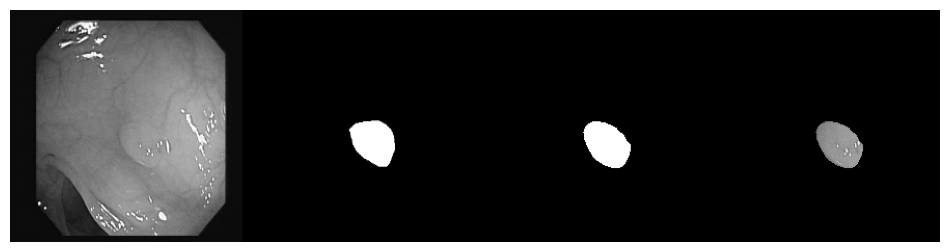

 Epoch: 53 of 100, Iter.: 46 of 46, Train Loss: 0.054536, IoU: 0.912389, Dice: 0.951375
 Epoch: 53 of 100, Iter.: 46 of 46, Valid Loss: 0.241620, IoU: 0.772433, Dice: 0.849476


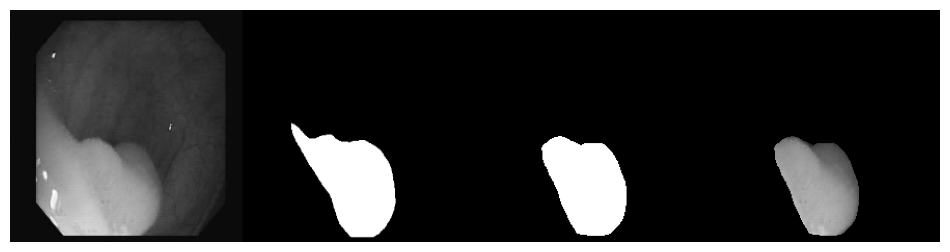

 Epoch: 54 of 100, Iter.: 46 of 46, Train Loss: 0.054663, IoU: 0.912821, Dice: 0.951595
 Epoch: 54 of 100, Iter.: 46 of 46, Valid Loss: 0.232526, IoU: 0.777155, Dice: 0.856281


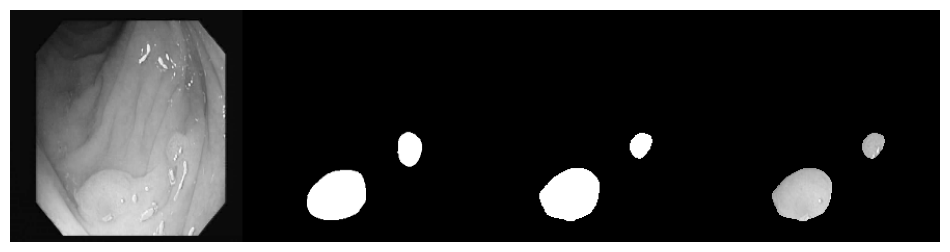

 Epoch: 55 of 100, Iter.: 46 of 46, Train Loss: 0.053430, IoU: 0.914923, Dice: 0.952911
 Epoch: 55 of 100, Iter.: 46 of 46, Valid Loss: 0.231852, IoU: 0.775842, Dice: 0.852634


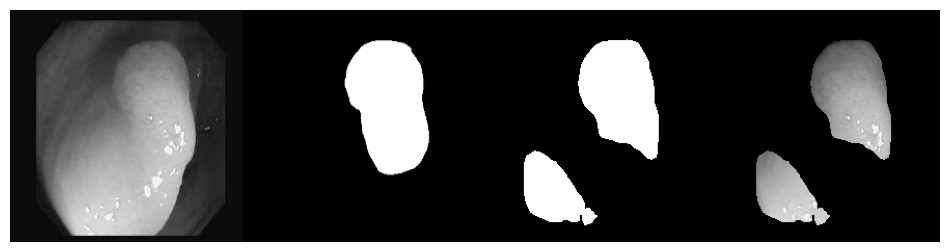

 Epoch: 56 of 100, Iter.: 46 of 46, Train Loss: 0.050859, IoU: 0.915669, Dice: 0.953121
 Epoch: 56 of 100, Iter.: 46 of 46, Valid Loss: 0.247151, IoU: 0.770365, Dice: 0.845533


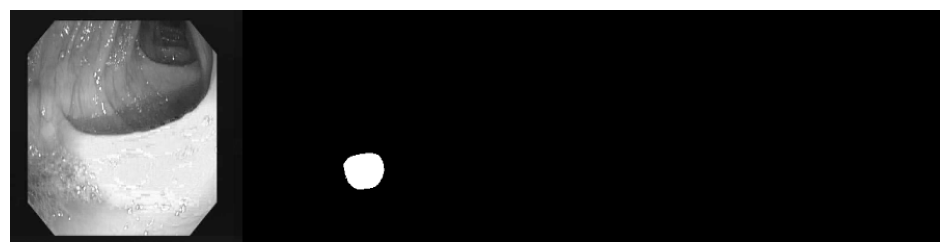

 Epoch: 57 of 100, Iter.: 46 of 46, Train Loss: 0.051262, IoU: 0.916768, Dice: 0.954129
 Epoch: 57 of 100, Iter.: 46 of 46, Valid Loss: 0.225229, IoU: 0.781019, Dice: 0.857230


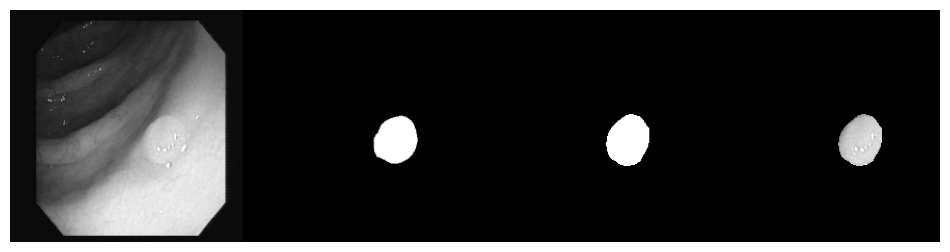

 Epoch: 58 of 100, Iter.: 46 of 46, Train Loss: 0.051226, IoU: 0.918960, Dice: 0.955896
 Epoch: 58 of 100, Iter.: 46 of 46, Valid Loss: 0.243561, IoU: 0.782301, Dice: 0.861589


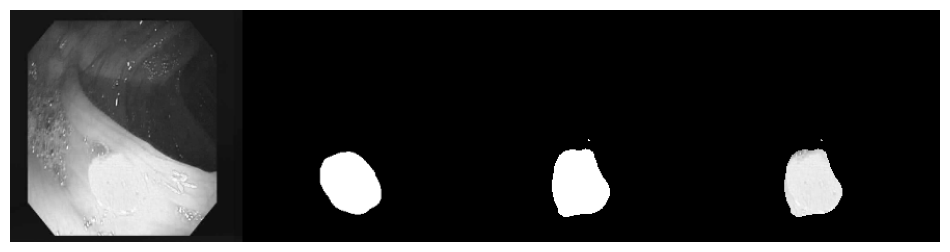

 Epoch: 59 of 100, Iter.: 46 of 46, Train Loss: 0.053748, IoU: 0.914601, Dice: 0.953724
 Epoch: 59 of 100, Iter.: 46 of 46, Valid Loss: 0.249658, IoU: 0.761368, Dice: 0.838911


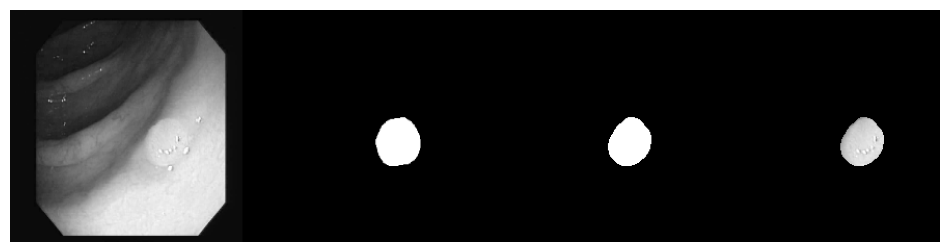

 Epoch: 60 of 100, Iter.: 46 of 46, Train Loss: 0.054688, IoU: 0.915242, Dice: 0.953023
 Epoch: 60 of 100, Iter.: 46 of 46, Valid Loss: 0.253836, IoU: 0.765578, Dice: 0.845397


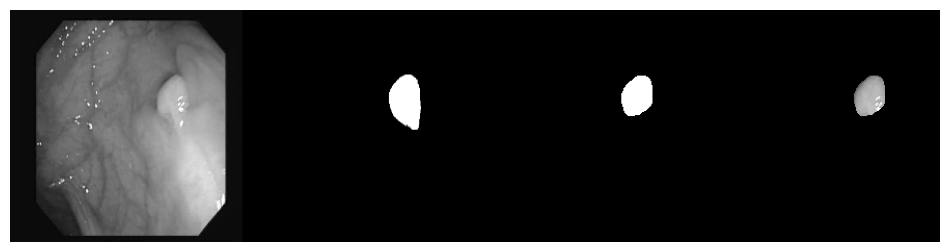

 Epoch: 61 of 100, Iter.: 46 of 46, Train Loss: 0.049511, IoU: 0.919287, Dice: 0.955569
 Epoch: 61 of 100, Iter.: 46 of 46, Valid Loss: 0.238161, IoU: 0.765297, Dice: 0.844381


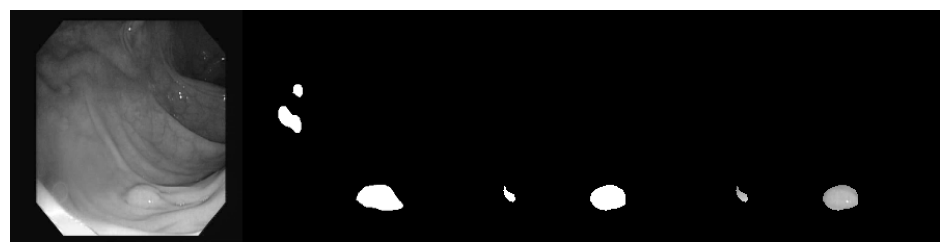

 Epoch: 62 of 100, Iter.: 46 of 46, Train Loss: 0.053032, IoU: 0.916288, Dice: 0.954115
 Epoch: 62 of 100, Iter.: 46 of 46, Valid Loss: 0.247258, IoU: 0.763427, Dice: 0.841421


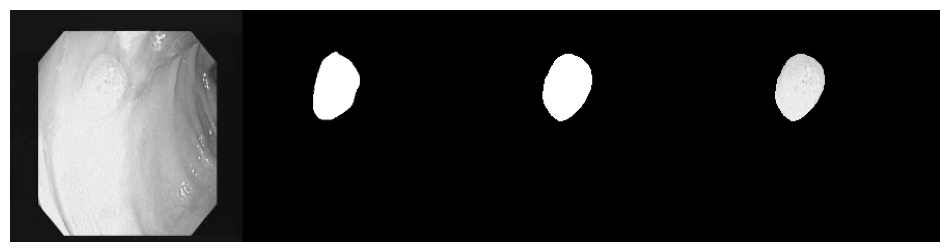

 Epoch: 63 of 100, Iter.: 46 of 46, Train Loss: 0.048227, IoU: 0.923467, Dice: 0.958886
 Epoch: 63 of 100, Iter.: 46 of 46, Valid Loss: 0.255798, IoU: 0.764272, Dice: 0.840055


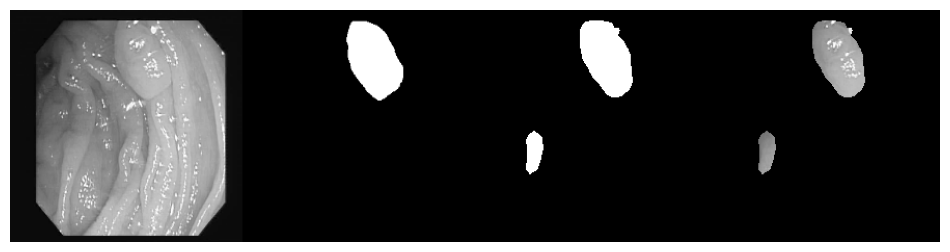

 Epoch: 64 of 100, Iter.: 46 of 46, Train Loss: 0.053077, IoU: 0.916460, Dice: 0.953705
 Epoch: 64 of 100, Iter.: 46 of 46, Valid Loss: 0.242142, IoU: 0.764944, Dice: 0.841187


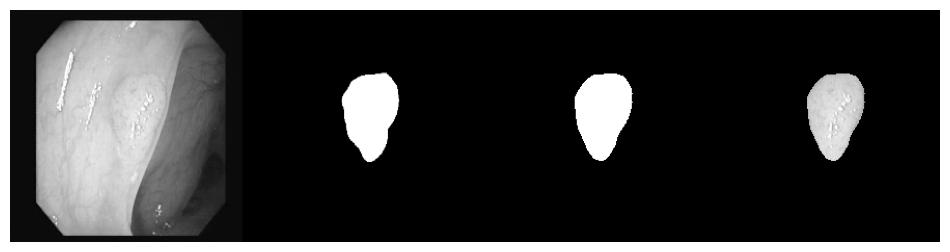

 Epoch: 65 of 100, Iter.: 46 of 46, Train Loss: 0.049995, IoU: 0.920123, Dice: 0.956771
 Epoch: 65 of 100, Iter.: 46 of 46, Valid Loss: 0.244906, IoU: 0.765450, Dice: 0.842895


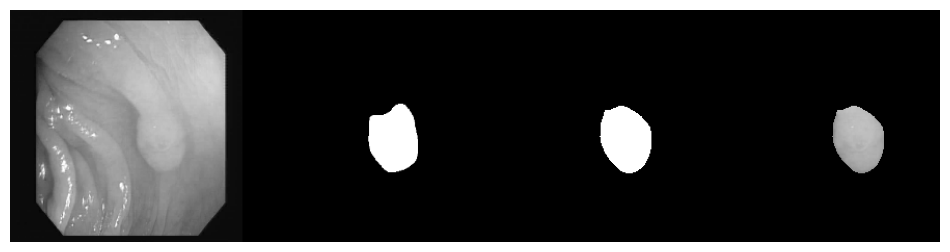

 Epoch: 66 of 100, Iter.: 46 of 46, Train Loss: 0.052616, IoU: 0.919526, Dice: 0.956144
 Epoch: 66 of 100, Iter.: 46 of 46, Valid Loss: 0.259016, IoU: 0.770280, Dice: 0.847993


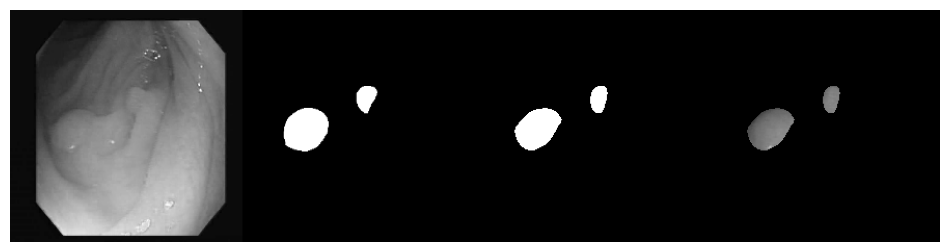

 Epoch: 67 of 100, Iter.: 46 of 46, Train Loss: 0.050905, IoU: 0.921460, Dice: 0.957499
 Epoch: 67 of 100, Iter.: 46 of 46, Valid Loss: 0.245776, IoU: 0.767386, Dice: 0.841083


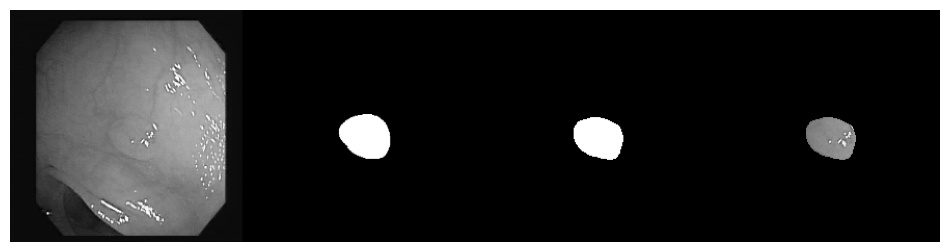

 Epoch: 68 of 100, Iter.: 46 of 46, Train Loss: 0.051851, IoU: 0.919471, Dice: 0.956444
 Epoch: 68 of 100, Iter.: 46 of 46, Valid Loss: 0.245818, IoU: 0.774592, Dice: 0.851718


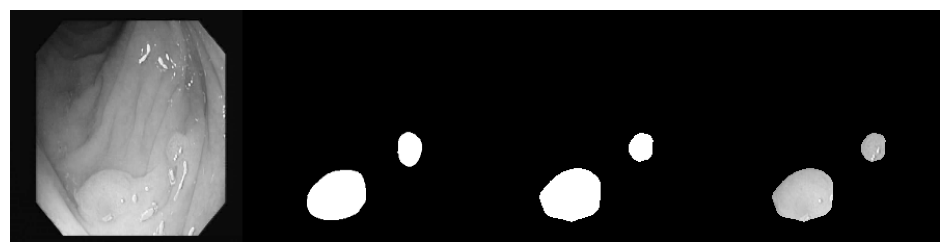

 Epoch: 69 of 100, Iter.: 46 of 46, Train Loss: 0.046770, IoU: 0.925002, Dice: 0.959927
 Epoch: 69 of 100, Iter.: 46 of 46, Valid Loss: 0.245112, IoU: 0.776230, Dice: 0.851622


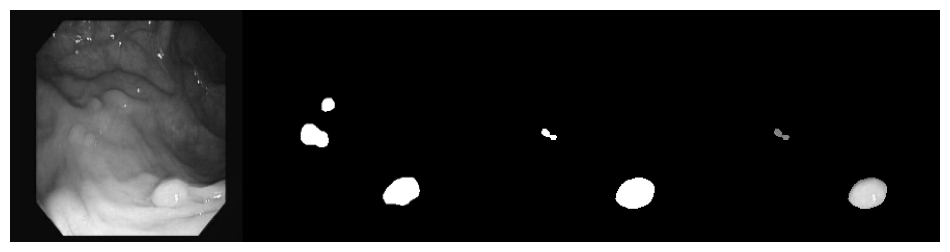

 Epoch: 70 of 100, Iter.: 46 of 46, Train Loss: 0.044039, IoU: 0.929295, Dice: 0.962323
 Epoch: 70 of 100, Iter.: 46 of 46, Valid Loss: 0.238605, IoU: 0.781885, Dice: 0.857461


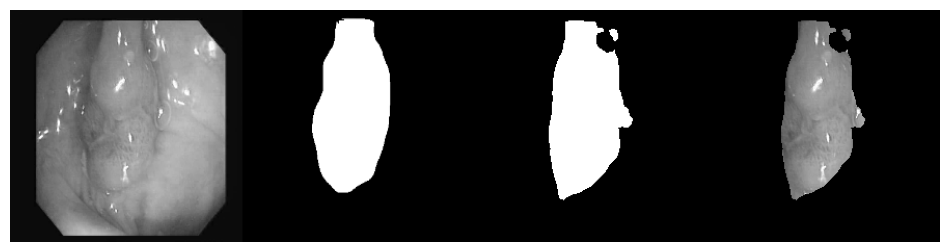

 Epoch: 71 of 100, Iter.: 46 of 46, Train Loss: 0.049523, IoU: 0.916802, Dice: 0.950515
 Epoch: 71 of 100, Iter.: 46 of 46, Valid Loss: 0.243331, IoU: 0.773577, Dice: 0.850335


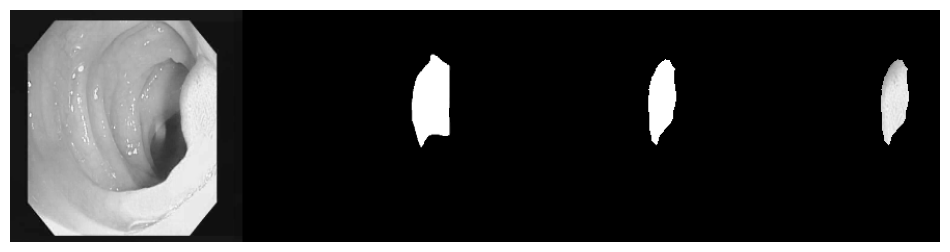

 Epoch: 72 of 100, Iter.: 46 of 46, Train Loss: 0.043187, IoU: 0.928831, Dice: 0.962042
 Epoch: 72 of 100, Iter.: 46 of 46, Valid Loss: 0.242452, IoU: 0.778236, Dice: 0.853772


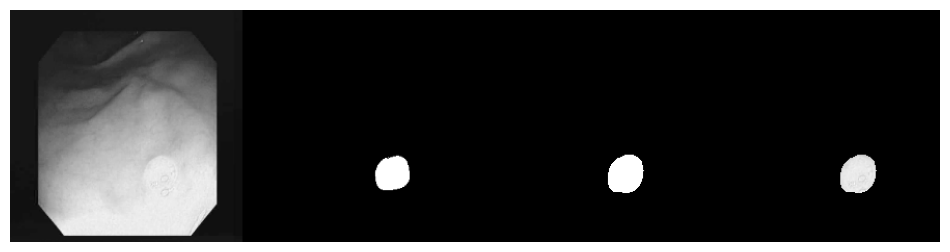

 Epoch: 73 of 100, Iter.: 46 of 46, Train Loss: 0.042268, IoU: 0.930975, Dice: 0.962152
 Epoch: 73 of 100, Iter.: 46 of 46, Valid Loss: 0.263292, IoU: 0.766121, Dice: 0.840981


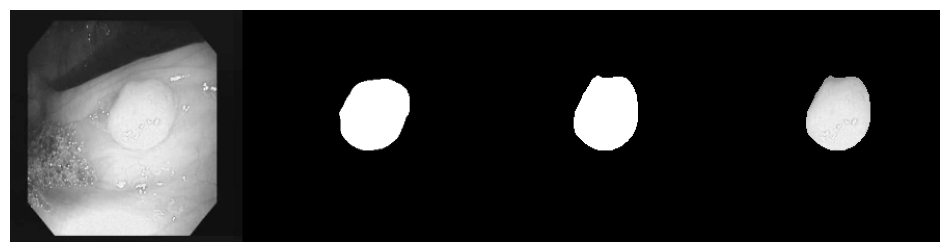

 Epoch: 74 of 100, Iter.: 46 of 46, Train Loss: 0.045613, IoU: 0.924434, Dice: 0.958117
 Epoch: 74 of 100, Iter.: 46 of 46, Valid Loss: 0.243658, IoU: 0.778255, Dice: 0.853309


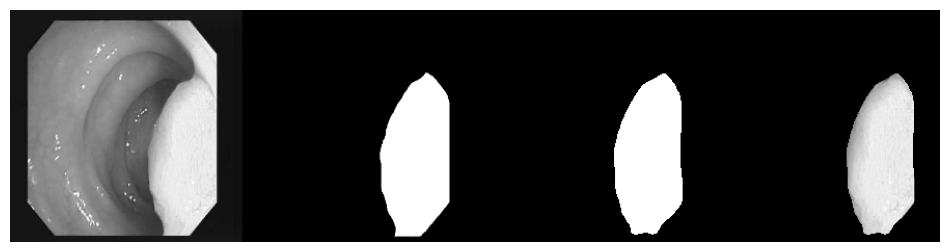

 Epoch: 75 of 100, Iter.: 46 of 46, Train Loss: 0.043766, IoU: 0.929290, Dice: 0.962108
 Epoch: 75 of 100, Iter.: 46 of 46, Valid Loss: 0.246774, IoU: 0.777979, Dice: 0.854187


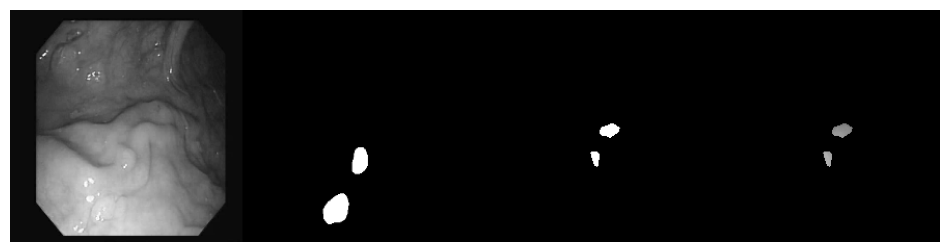

 Epoch: 76 of 100, Iter.: 46 of 46, Train Loss: 0.041280, IoU: 0.933549, Dice: 0.964544
 Epoch: 76 of 100, Iter.: 46 of 46, Valid Loss: 0.239277, IoU: 0.777347, Dice: 0.852570


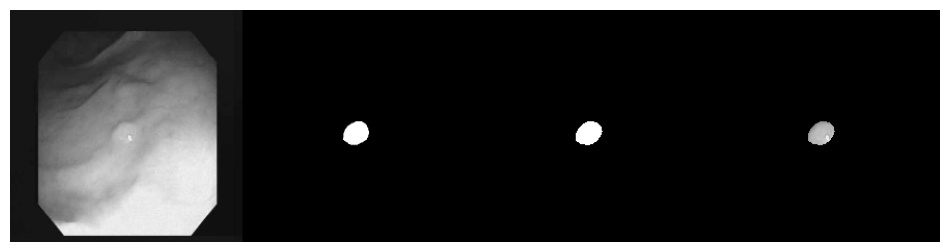

 Epoch: 77 of 100, Iter.: 46 of 46, Train Loss: 0.049511, IoU: 0.923406, Dice: 0.957463
 Epoch: 77 of 100, Iter.: 46 of 46, Valid Loss: 0.227460, IoU: 0.771713, Dice: 0.849292


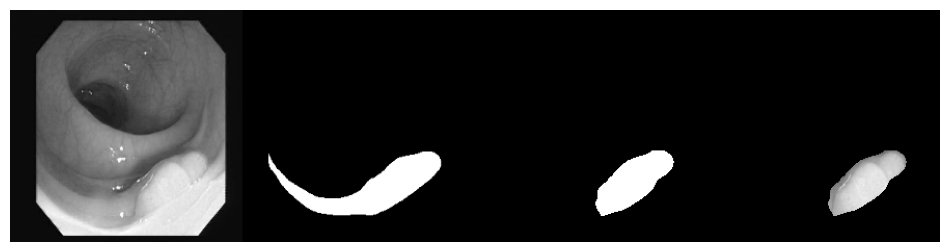

 Epoch: 78 of 100, Iter.: 46 of 46, Train Loss: 0.049402, IoU: 0.923626, Dice: 0.958810
 Epoch: 78 of 100, Iter.: 46 of 46, Valid Loss: 0.239363, IoU: 0.773818, Dice: 0.847940


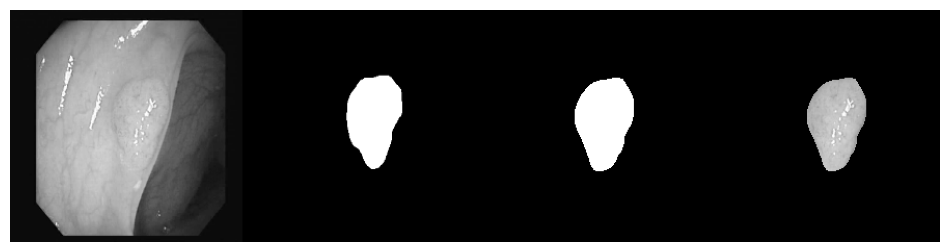

 Epoch: 79 of 100, Iter.: 46 of 46, Train Loss: 0.043087, IoU: 0.932237, Dice: 0.964095
 Epoch: 79 of 100, Iter.: 46 of 46, Valid Loss: 0.235810, IoU: 0.775811, Dice: 0.851922


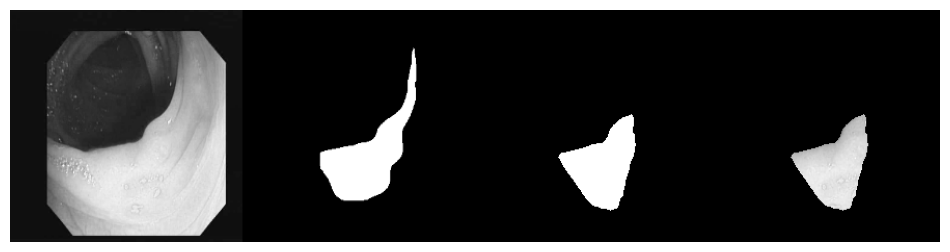


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 14min 24s, sys: 9min 52s, total: 24min 17s
Wall time: 18min 22s


In [12]:
%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/ehdgus575/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

In [ ]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
#print(f'End_time: {end_time}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()

Validationset 기준 
Best_epoch:58, Best_IOU:0.7823, Best_DiceScore:0.8616
